8. Reinf learning. Exercise: Use policy gradients to solve OpenAI Gym's LunarLander-v2 environment. You will need to install the Box2D dependencies (%pip install -U gym[box2d]).

In [3]:
import gym
env = gym.make("LunarLander-v2")
obs = env.reset()
obs

array([ 1.1956214e-03,  1.4201959e+00,  1.2109010e-01,  4.1225168e-01,
       -1.3786494e-03, -2.7428711e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

Discrete(4)

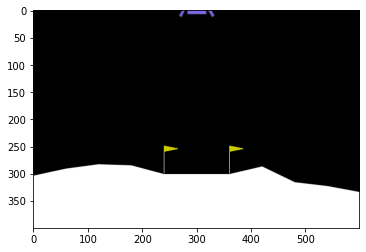

In [12]:
import matplotlib.pyplot as plt
img = env.render(mode="rgb_array")
plt.imshow(img)
env.action_space